## Midterm project: application of topic materials 1- 6

<img src="Yerevan_PageRank.gif" width="1000" align="center">

In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

epsg:4326
+proj=utm +zone=38 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


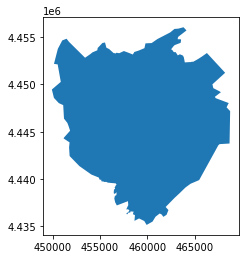

In [2]:
# load yerevan city from openstreetmap using osmmnx api
city = ox.geocode_to_gdf("Yerevan, Armenia")
print(city.crs)
city = ox.projection.project_gdf(city)
ax = city.plot(ec='none')
#_ = ax.axis('off')
print(city.crs)

<AxesSubplot:>

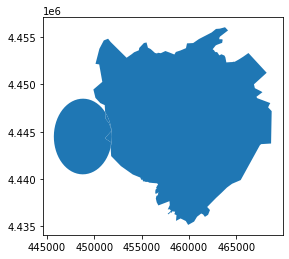

In [3]:
#39.9042° N, 116.4074° E
circle = Point(44.3989, 40.1492).buffer(4*0.00899928)
c = gpd.GeoSeries(circle)

from pyproj import CRS
crs = CRS.from_epsg(4326)

df1 = gpd.GeoDataFrame({'geometry': c, 'df1':[1]}, crs=crs)
df = df1.to_crs(city.crs)
city_union = gpd.overlay(df, city, how='union')
city_union.plot()

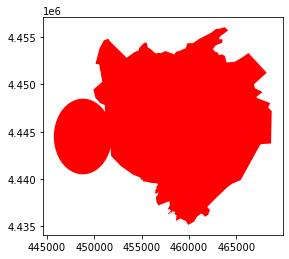

In [4]:
from shapely.ops import cascaded_union
polygons = [city_union['geometry'].iloc[0], city_union['geometry'].iloc[1], city_union['geometry'].iloc[2]]
boundary = gpd.GeoSeries(cascaded_union(polygons))
boundary.plot(color = 'red')
plt.show()

<AxesSubplot:>

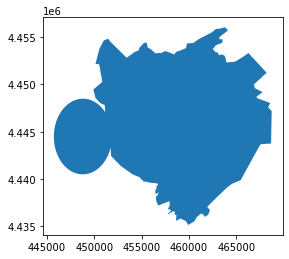

In [5]:
yerevan = gpd.GeoDataFrame({'geometry': boundary}, crs=city.crs)
yerevan.plot()

In [6]:
y = yerevan.to_crs(crs)
w, s, e, n = y.unary_union.bounds
w

44.36290288

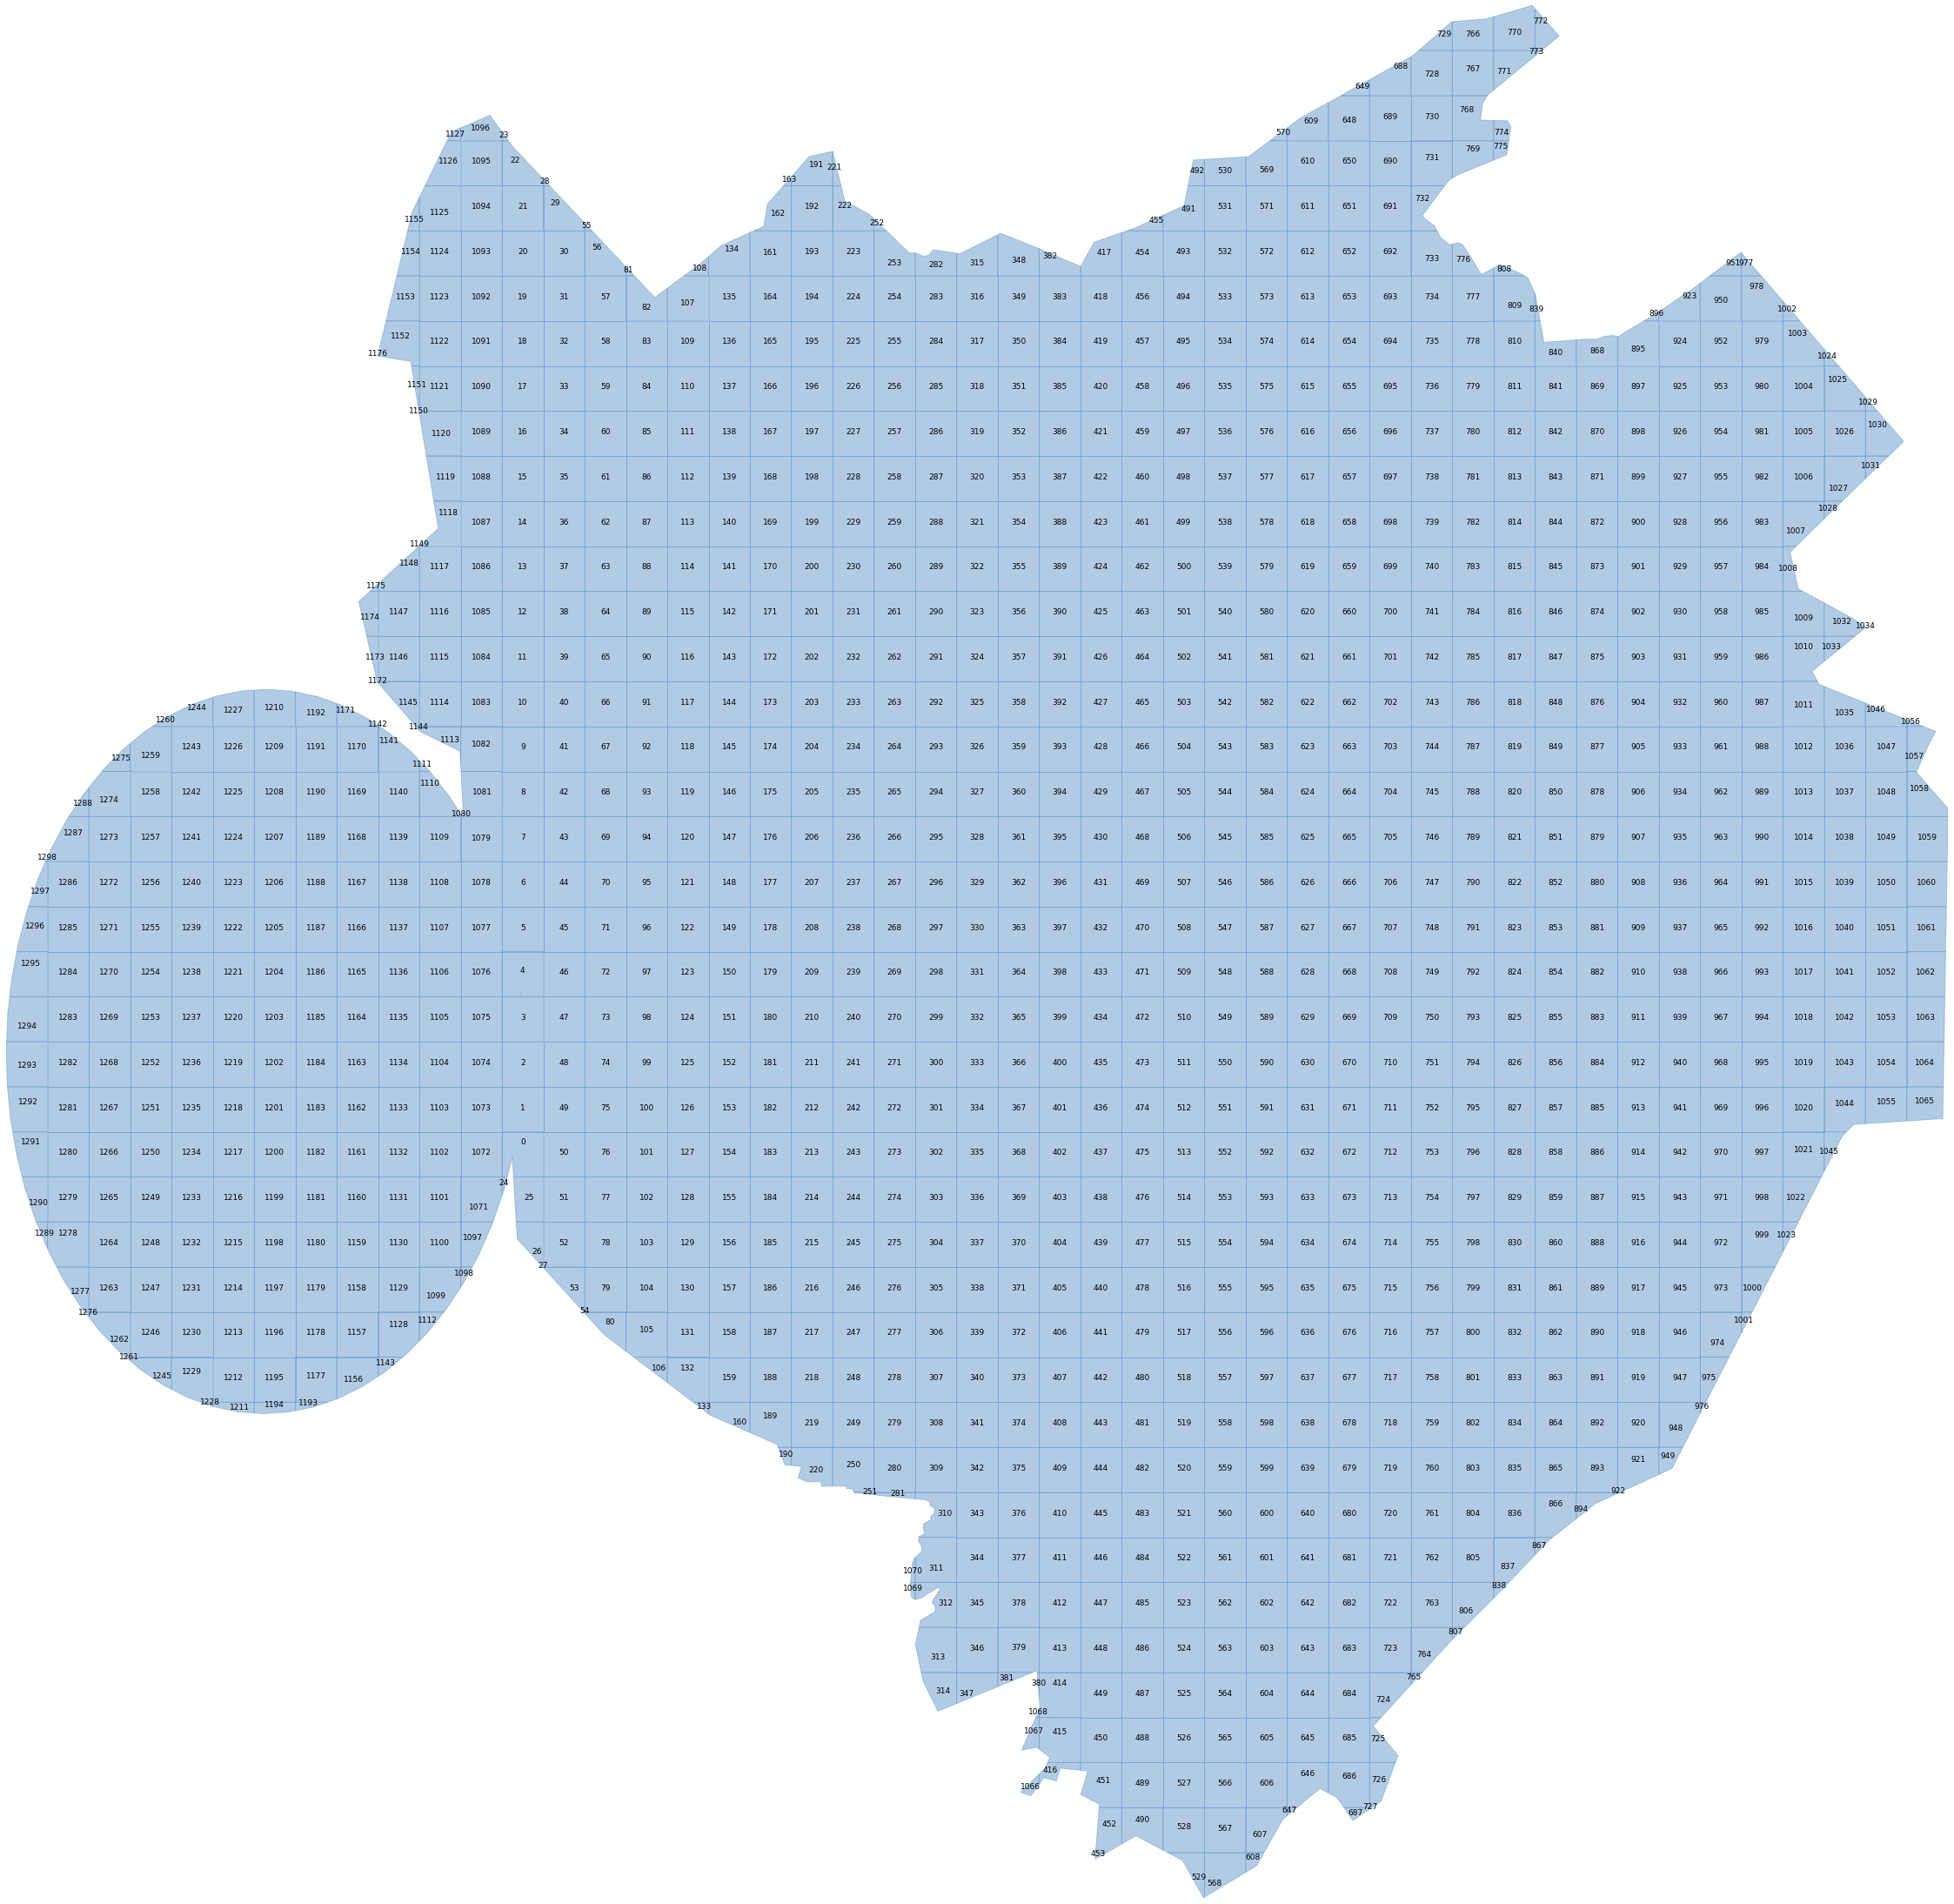

In [7]:
# make the geometry a multipolygon if it's not already
geometry = yerevan['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=500)

yerevan['coords'] = yerevan['geometry'].apply(lambda x: x.representative_point().coords[:])
yerevan['coords'] = [coords[0] for coords in yerevan['coords']]

polylist = [p for p in geometry_cut]

west, south, east, north = yerevan.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#6699cc', ec='#6699cc', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p,
                 horizontalalignment='center', size=9)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [8]:
polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = yerevan.geometry.crs
polyframe.tail()

,geometry
1294,"POLYGON ((445739.798 4444597.770, 445753.506 4..."
1295,"POLYGON ((445776.708 4445094.838, 445800.431 4..."
1296,"POLYGON ((445860.548 4445591.907, 445876.254 4..."
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4..."
1298,"POLYGON ((446202.021 4446586.043, 446225.421 4..."


In [9]:
# import gps data set
data = pd.read_csv('../data/Yerevan_gps_data.csv', header=0, index_col=0)
print(len(data))
data.tail()

C:\Users\gevor\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


18155834


,createdAt,partnerId,lat,lon,status
18155829,2019-03-31 21:14:05,279826,40.181720,44.521299,0
18155830,2019-03-31 21:14:21,279826,40.180491,44.522924,0
18155831,2019-03-31 21:14:37,279826,40.180423,44.522933,0
18155832,2019-03-31 21:14:53,279826,40.180408,44.522929,0
18155833,2019-03-31 21:15:01,279826,40.180407,44.522929,0


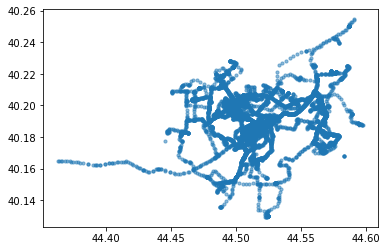

In [10]:
# plot sample data
plt.scatter(data.loc[:10000, 'lon'],data.loc[:10000, 'lat'], alpha=0.5, s=10)
plt.show()

In [11]:
geometry = [Point(xy) for xy in zip(data.lon, data.lat)] #list comprehension
crs = CRS.from_epsg(4326)
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
gdf.head()

,createdAt,partnerId,lat,lon,status,geometry
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (44.44599 40.17727)
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (44.49610 40.19993)
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (44.49610 40.19993)
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (44.57209 40.17507)
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (44.57210 40.17505)


In [12]:
#reproject geometry to yerevan grid crs
gdf.geometry = gdf.geometry.to_crs(yerevan.geometry.crs)
gdf.head()

,createdAt,partnerId,lat,lon,status,geometry
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (452832.035 4447579.433)
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (457112.862 4450069.794)
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (457112.862 4450069.794)
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (463567.204 4447276.695)
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (463568.220 4447273.748)


In [13]:
gdf.crs

<Projected CRS: +proj=utm +zone=38 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 38N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# do a spatial join operation to identify which points fall into which grid cell
pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print(len(pointInPoly))
pointInPoly.tail()

17961137


,geometry,index_right,createdAt,partnerId,lat,lon,status
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",4421369,2019-03-16 21:07:32,76947,40.164898,44.368023,0
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",4018631,2019-03-16 16:04:31,71789,40.164901,44.368167,0
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",24149,2019-03-17 23:13:58,33,40.164854,44.368300,0
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",399622,2019-03-28 10:02:41,316,40.164860,44.368061,0
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",7121670,2019-03-23 22:11:26,119601,40.164428,44.367215,0


In [15]:
pointInPoly.sort_values(['partnerId', 'createdAt'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)
pointInPoly.head()

,geometry,index_right,createdAt,partnerId,lat,lon,status,index
0,"POLYGON ((453078.220 4447580.180, 453078.220 4...",0,2019-03-31 15:11:10,2,40.177266,44.445987,0,68
1,"POLYGON ((457483.591 4450562.590, 457483.591 4...",1,2019-03-15 16:29:56,12,40.199932,44.496100,0,321
2,"POLYGON ((457483.591 4450562.590, 457483.591 4...",2,2019-03-15 16:30:27,12,40.199932,44.496100,0,321
3,"POLYGON ((463846.905 4447580.180, 463846.905 4...",3,2019-03-18 20:17:29,12,40.175073,44.572091,0,820
4,"POLYGON ((463846.905 4447580.180, 463846.905 4...",4,2019-03-18 20:17:45,12,40.175047,44.572103,0,820


In [16]:
present_ind = list(pointInPoly['index_right'])
len(present_ind)

17961137

In [17]:
gdf_test = gdf.copy()
gdf_test.head()

,createdAt,partnerId,lat,lon,status,geometry
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (452832.035 4447579.433)
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (457112.862 4450069.794)
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (457112.862 4450069.794)
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (463567.204 4447276.695)
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (463568.220 4447273.748)


In [18]:
# keep only those points that are within the gridded polygons
gdf_test_dropped = gdf_test.iloc[present_ind,:]
len(gdf_test_dropped)

17961137

In [19]:
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped['present_index'] = gdf_dropped.index
gdf_dropped.tail()

,createdAt,partnerId,lat,lon,status,geometry,present_index
18155829,2019-03-31 21:14:05,279826,40.181720,44.521299,0,POINT (459246.644 4448036.536),18155829
18155830,2019-03-31 21:14:21,279826,40.180491,44.522924,0,POINT (459384.262 4447899.424),18155830
18155831,2019-03-31 21:14:37,279826,40.180423,44.522933,0,POINT (459385.038 4447891.805),18155831
18155832,2019-03-31 21:14:53,279826,40.180408,44.522929,0,POINT (459384.663 4447890.098),18155832
18155833,2019-03-31 21:15:01,279826,40.180407,44.522929,0,POINT (459384.654 4447890.075),18155833


In [20]:
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.tail()

,createdAt,partnerId,lat,lon,status,geometry,present_index
17961132,2019-03-31 21:14:05,279826,40.181720,44.521299,0,POINT (459246.644 4448036.536),18155829
17961133,2019-03-31 21:14:21,279826,40.180491,44.522924,0,POINT (459384.262 4447899.424),18155830
17961134,2019-03-31 21:14:37,279826,40.180423,44.522933,0,POINT (459385.038 4447891.805),18155831
17961135,2019-03-31 21:14:53,279826,40.180408,44.522929,0,POINT (459384.663 4447890.098),18155832
17961136,2019-03-31 21:15:01,279826,40.180407,44.522929,0,POINT (459384.654 4447890.075),18155833


In [21]:
pointInPoly.tail()

,geometry,index_right,createdAt,partnerId,lat,lon,status,index
17961132,"POLYGON ((459441.534 4448077.248, 459441.534 4...",18155829,2019-03-31 21:14:05,279826,40.181720,44.521299,0,466
17961133,"POLYGON ((459441.534 4448077.248, 459441.534 4...",18155830,2019-03-31 21:14:21,279826,40.180491,44.522924,0,466
17961134,"POLYGON ((459441.534 4448077.248, 459441.534 4...",18155831,2019-03-31 21:14:37,279826,40.180423,44.522933,0,466
17961135,"POLYGON ((459441.534 4448077.248, 459441.534 4...",18155832,2019-03-31 21:14:53,279826,40.180408,44.522929,0,466
17961136,"POLYGON ((459441.534 4448077.248, 459441.534 4...",18155833,2019-03-31 21:15:01,279826,40.180407,44.522929,0,466


In [22]:
# sanity check to make sure polygons containing the GPS points have the correct indices
polyframe.iloc[466].geometry.contains(gdf_dropped.iloc[17961136][5])

True

In [23]:
# change vehicle status to only 0 (idle) and 1 (occupied)
gdf_dropped.loc[gdf_dropped.status==2,'status'] = 0
gdf_dropped.loc[gdf_dropped.status==3,'status'] = 1
gdf_dropped.status.unique()

array([0, 1], dtype=int64)

In [24]:
# for each vehicle create create a 'trip' attribute counting the number of trips
gdf_dropped['trip'] = gdf_dropped.groupby('partnerId').apply(lambda x: x['status'].ne(x['status'].shift()).cumsum()).tolist()
gdf_dropped.tail()

,createdAt,partnerId,lat,lon,status,geometry,present_index,trip
17961132,2019-03-31 21:14:05,279826,40.181720,44.521299,0,POINT (459246.644 4448036.536),18155829,429
17961133,2019-03-31 21:14:21,279826,40.180491,44.522924,0,POINT (459384.262 4447899.424),18155830,429
17961134,2019-03-31 21:14:37,279826,40.180423,44.522933,0,POINT (459385.038 4447891.805),18155831,429
17961135,2019-03-31 21:14:53,279826,40.180408,44.522929,0,POINT (459384.663 4447890.098),18155832,429
17961136,2019-03-31 21:15:01,279826,40.180407,44.522929,0,POINT (459384.654 4447890.075),18155833,429


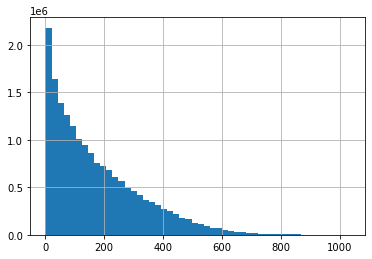

In [25]:
gdf_dropped.trip.hist(bins=50)
plt.show()

In [26]:
gdf_dropped['pindex'] = pointInPoly['index']
#check if there are any missing values
print(gdf_dropped.isna().values.any())
gdf_dropped.tail()

False


,createdAt,partnerId,lat,lon,status,geometry,present_index,trip,pindex
17961132,2019-03-31 21:14:05,279826,40.181720,44.521299,0,POINT (459246.644 4448036.536),18155829,429,466
17961133,2019-03-31 21:14:21,279826,40.180491,44.522924,0,POINT (459384.262 4447899.424),18155830,429,466
17961134,2019-03-31 21:14:37,279826,40.180423,44.522933,0,POINT (459385.038 4447891.805),18155831,429,466
17961135,2019-03-31 21:14:53,279826,40.180408,44.522929,0,POINT (459384.663 4447890.098),18155832,429,466
17961136,2019-03-31 21:15:01,279826,40.180407,44.522929,0,POINT (459384.654 4447890.075),18155833,429,466


In [27]:
# check datafrane length
len(gdf_dropped)

17961137

In [28]:
# make a total trip counter for the entire dataset
gdf_dropped['trips'] = gdf_dropped['trip'].ne(gdf_dropped['trip'].shift()).cumsum()
gdf_dropped['trips'] = gdf_dropped['trips']+gdf_dropped['partnerId']
gdf_dropped['trips'] = pd.factorize(gdf_dropped.trips)[0] + 1
gdf_dropped.tail()

,createdAt,partnerId,lat,lon,status,geometry,present_index,trip,pindex,trips
17961132,2019-03-31 21:14:05,279826,40.181720,44.521299,0,POINT (459246.644 4448036.536),18155829,429,466,308543
17961133,2019-03-31 21:14:21,279826,40.180491,44.522924,0,POINT (459384.262 4447899.424),18155830,429,466,308543
17961134,2019-03-31 21:14:37,279826,40.180423,44.522933,0,POINT (459385.038 4447891.805),18155831,429,466,308543
17961135,2019-03-31 21:14:53,279826,40.180408,44.522929,0,POINT (459384.663 4447890.098),18155832,429,466,308543
17961136,2019-03-31 21:15:01,279826,40.180407,44.522929,0,POINT (459384.654 4447890.075),18155833,429,466,308543


In [29]:
gdf_c = gdf_dropped.copy()
gdf_c.drop(['present_index', 'status', 'trip'], axis=1, inplace=True)
gdf_c.head()

,createdAt,partnerId,lat,lon,geometry,pindex,trips
0,2019-03-31 15:11:10,2,40.177266,44.445987,POINT (452832.035 4447579.433),68,1
1,2019-03-15 16:29:56,12,40.199932,44.496100,POINT (457112.862 4450069.794),321,2
2,2019-03-15 16:30:27,12,40.199932,44.496100,POINT (457112.862 4450069.794),321,2
3,2019-03-18 20:17:29,12,40.175073,44.572091,POINT (463567.204 4447276.695),820,2
4,2019-03-18 20:17:45,12,40.175047,44.572103,POINT (463568.220 4447273.748),820,2


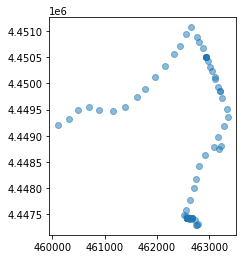

In [30]:
gdf_c.loc[gdf_c.trips==100].plot(alpha=0.5)
plt.show()

## Building the mobility networks

### Column names:
    
"createdAt" - timestamp \
"partnerId" - vehicle ID \
"trips" - number of trip the point belongs to \
"pindex" - polygon index the point belongs to

In [31]:
gdf = gdf_c.copy()
# number of trips
print(len(gdf.trips.unique()))

308543


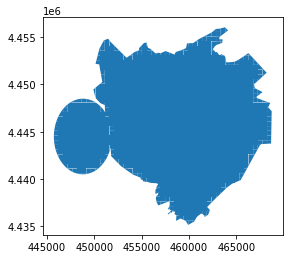

In [32]:
# copy city polygon dataframe
city =  polyframe.copy()
city.plot()
plt.show()

In [34]:
from tqdm import tqdm

def origins_counter(gdf):
    
    """
    This function takes as input a (Geo)DataFrame containing a "trips" attribute assigning each data point to a given trip,
    and returns a DataFrame containing the origin points of each trip.
    """
    
    origins_df = gdf.loc[gdf['trips']==1, :][:1]
    for trip in tqdm(gdf['trips'].unique()):
        df = gdf[gdf['trips']==trip][:1]
        origins_df = pd.concat([origins_df, df], axis=0, ignore_index=True)
    return origins_df

origins_DF = origins_counter(gdf)
origins_DF.head()

100%|██████████████████████████████████████████████████████████████████████| 308543/308543 [6:35:42<00:00, 13.00it/s]


,createdAt,partnerId,lat,lon,geometry,pindex,trips
0,2019-03-31 15:11:10,2,40.177266,44.445987,POINT (452832.035 4447579.433),68,1
1,2019-03-31 15:11:10,2,40.177266,44.445987,POINT (452832.035 4447579.433),68,1
2,2019-03-15 16:29:56,12,40.199932,44.496100,POINT (457112.862 4450069.794),321,2
3,2019-03-18 21:35:18,12,40.190110,44.526218,POINT (459670.436 4448965.522),502,3
4,2019-03-18 21:53:02,12,40.209576,44.534560,POINT (460391.793 4451122.433),536,4


In [ ]:
def dest_counter(gdf):
    
    """ 
    This function takes as input a (Geo)DataFrame containing a "trips" attribute assigning each data point to a given trip,
    and returns a DataFrame containing the destination points of each trip.
    """
    
    destination_df = gdf.loc[gdf['trips']==1, :][-1:]
    for trip in tqdm(gdf['trips'].unique()):
        df = gdf[gdf['trips']==trip][-1:]
        destination_df = pd.concat([destination_df, df], axis=0, ignore_index=True)
    return destination_df

destinations_DF = dest_counter(gdf)
destinations_DF.head()

### Code parallelisation

In [ ]:
# create two dataframes: one for origins and one for destinations

origins_DF = gdf.loc[gdf['trips']==1, :][:1]
destinations_DF = gdf.loc[gdf['trips']==1, :][-1:]
origins_DF.head()

In [ ]:
# import libraries for parallelising code, as well as custom made functions for counting origins and destinations

import multiprocessing 
import origins_counter
import destination_counter 
from tqdm import tqdm

In [ ]:
# factorize number of trips to utilise code parallelisation
len(gdf['trips'].unique()) == 269*31*37

In [ ]:
# block of code building the origins dataframe
results = []
pool = multiprocessing.Pool(processes=8)

i = 0
unique = gdf['trips'].unique()
trip_per_async = 269
for t in tqdm(range(0, len(unique), trip_per_async)):
    hi = unique[t+trip_per_async-1]
    lo = unique[t]
    df = gdf[(gdf['trips'] >= lo) & (gdf['trips'] <= hi)]
    results.append(pool.apply_async(origins_counter.origins_counter, (df,)))
    i += 1
    if i % 50:
        for r in results:
            odf = r.get()
            origins_DF = pd.concat([origins_DF, odf], axis=0, ignore_index=True)
        results = []

pool.close()
pool.join()   
print('done')
    
print(len(origins_DF))
origins_DF.tail()

In [ ]:
# block of code building the destinations dataframe
results = []
pool = multiprocessing.Pool(processes=8)

i = 0
unique = gdf['trips'].unique()
trip_per_async = 269
for t in tqdm(range(0, len(unique), trip_per_async)):
    hi = unique[t+trip_per_async-1]
    lo = unique[t]
    df = gdf[(gdf['trips'] >= lo) & (gdf['trips'] <= hi)]
    results.append(pool.apply_async(destination_counter.dest_counter, (df,)))
    i += 1
    if i % 50:
        for r in results:
            odf = r.get()
            destinations_DF = pd.concat([destinations_DF, odf], axis=0, ignore_index=True)
        results = []

pool.close()
pool.join()   
print('done')
    
print(len(destinations_DF))
destinations_DF.tail()

### Building the Origin-Destination DataFrame

In [ ]:
# clean and finalise the dataframes
origins_DF = origins_DF[2:]
origins_DF.reset_index(drop=True, inplace=True)
origins_DF = origins_DF.copy()

destinations_DF = destinations_DF[2:]
destinations_DF.reset_index(drop=True, inplace=True)
destinations_DF = destinations_DF.copy()
destinations_DF.head(10)

In [ ]:
# set timestamp as index
origins_DF = origins_DF.set_index('createdAt')
destinations_DF = destinations_DF.set_index('createdAt')
destinations_DF.head(10)

In [ ]:
# start building the origin-destination matrix in dataframe format
num_poly = len(city)
origs = []
dests = []
for i in range(num_poly):
    for j in range(num_poly):
        origs.append(i)
        dests.append(j)
print(len(origs), len(dests))

data = pd.DataFrame({'origins': origs, 'destinations': dests})
data.head()

In [ ]:
# for each hour of the day, add a new column for the OD flows during that hour
from tqdm import tqdm
print(data.shape)
print('\n')
for hour in tqdm(range(1, 25)):
    mat = np.zeros(shape=(num_poly, num_poly), dtype=np.uint16)
    time_mat = np.zeros(shape=(num_poly, num_poly))
    hour_orig_df = origins_DF.between_time(start_time='{}:00:00'.format((hour-1)%24), end_time='{}:00:00'.format(hour%24))
    hour_dest_df = destinations_DF[destinations_DF.trips.isin(hour_orig_df.trips.unique())]
    for trip in tqdm(hour_orig_df.trips.unique()):
        if (hour_dest_df[hour_dest_df.trips==trip].index - hour_orig_df[hour_orig_df.trips==trip].index).total_seconds().item() < 21000:
            mat[hour_orig_df[hour_orig_df.trips==trip].pindex.iloc[0], hour_dest_df[hour_dest_df.trips==trip].pindex.iloc[0]] += 1
            time_mat[hour_orig_df[hour_orig_df.trips==trip].pindex.iloc[0], 
                     hour_dest_df[hour_dest_df.trips==trip].pindex.iloc[0]] += (hour_dest_df[hour_dest_df.trips==trip].index - hour_orig_df[hour_orig_df.trips==trip].index).total_seconds().item()
        else:
            pass
    np.seterr(divide='ignore')
    #time = time/len(hour_orig_df.trips.unique())
    od1 = mat.astype(int)
    #time = np.where(od1!=0,np.ceil(np.nan_to_num(time / od1)), 0)
    time_mat = np.where(od1>0, np.ceil(time_mat/od1), 0)
    time_mat = time_mat.astype(int)
    print(od1)
    print('\n')
    print(time_mat)
    print('\n')
    flows = od1.flatten()
    time_diff = time_mat.flatten()
    data['hour_{}'.format(hour)] = flows
    data['time_{}'.format(hour)] = time_diff
    print(data.shape)
    print('\n')
    print('\n')
    
data.head()

In [ ]:
# save dataframe 
data.to_csv('../data/Yerevan_hourly_rides.csv')

In [37]:
data = pd.read_csv('../data/Yerevan_hourly_rides.csv', index_col=0)
data.head()

C:\Users\gevor\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,origins,destinations,hour_1,time_1,hour_2,time_2,hour_3,time_3,hour_4,time_4,...,hour_20,time_20,hour_21,time_21,hour_22,time_22,hour_23,time_23,hour_24,time_24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Homework assignments

Replicate this Jupyter Notebook either as is, or with other data, and do a general review of classes 1-6.